# Predicting Knowledge Level Using User Knowledge Data

A user knowledge model is a model that tries to build up a conceptual understanding of its users. In the context of a learning environment, this means that a learning system can adapt to how a certain user is learning new concepts based on their individual learning ability. As such, having a well-built user knowledge model is invaluable in creating adaptive, online learning environments. 

We are using a user knowledge modeling data set collected by Hamdi Tolga Kahraman to answer the following question:

**How high will somebody’s knowledge score be based on their study time, exam performance, and prerequisite knowledge?**

The data set contains 405 observations from on subjects who both prepared for and took an exam on Electrical DC Machines. The subjects prepared for and took two exams: one on prerequisite material, and one on targeted material whose knowledge built upon the prerequisite material. It includes columns for the degree of study time for both prerequisite knowledge and new knowledge bases, exam performances for both prerequisite knowledge and new knowledge bases, the degree of repetition, and the user’s knowledge level. The user knowledge level column has four categories: very low, low, middle, and high. We found no information on the age group or educational background of the participants.  


All columns are recognized as type double except for the level of the user’s knowledge (which is a character variable). The data appears to be already normalized because all values (other than the user’s knowledge level) fit between values of 0 and 1. The data is very close to being tidy - other than a description of the data in an extra column, the literal data itself is tidy. 

________________________________________________________________________________________________________________________

# *Data Analysis*
Let's begin by analyzing our data. First, of course, we must load the libraries and set our seed. 

In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(GGally)
library(cowplot)

set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Then, we'll read our dataset from the web. This includes cleaning and wrangling it into a tidy format. To clean and wrangle it, we need to unselect the two empty columns and the column with the description of the data, rename the columns and mutate our classification label to a factor data type. We will keep all predictor variables for now, since we will use methods to decide which predictors we will use later.

In [5]:
downloaded_data <- download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
                                "knowledge.xls")

user_knowledge_data <- read_excel("knowledge.xls", 
                                  sheet = 2) %>%  #data we want is on page 2 of the excel file
    select(-"...7", -"...8", -"Attribute Information:")  # unselect unnecessary columns

# rename columns
colnames(user_knowledge_data) <- c("targeted_study_time", 
                                   "repetition", 
                                   "prereq_study_time", 
                                   "prereq_exam_performance", 
                                   "targeted_exam_performance", 
                                   "understanding_level")

# change class label to factor 
user_knowledge_data <- user_knowledge_data %>%
    mutate(understanding_level = as_factor(understanding_level)) 

head(user_knowledge_data)

New names:
* `` -> ...7
* `` -> ...8



targeted_study_time,repetition,prereq_study_time,prereq_exam_performance,targeted_exam_performance,understanding_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


Now that we've cleaned and wrangled our data, we can split it between a testing and training set. We did not discuss `prop` values in class, so we will go with a default 75% split. We'll put the testing set aside for now.

In [6]:
set.seed(1)
knowledge_split <- initial_split(user_knowledge_data, prop = .75, strata = understanding_level)
knowledge_train <- training(knowledge_split)
knowledge_test <- testing(knowledge_split)

## Examining Our Data
Next, we can summarize the training data in informative tables. We'll include the following tables:
- means, max, min of each predictor
- how many of each label exist in the data frame

In [7]:
knowledge_train_means <- knowledge_train %>%
    summarize(target_study_time_mean = mean(targeted_study_time),
          repetition_mean = mean(repetition),
          prereq_study_time_mean = mean(prereq_study_time),
          prereq_exam_performance_mean = mean(prereq_exam_performance),
          targeted_exam_performance_mean = mean(targeted_exam_performance)) 
knowledge_train_means

target_study_time_mean,repetition_mean,prereq_study_time_mean,prereq_exam_performance_mean,targeted_exam_performance_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3750154,0.3527385,0.4640769,0.4234872,0.4546821


Let's discuss the `mean` table. We can see that the data seems well scaled since the means are all within a similar range. This means that we may not need to scale/center our data, although we will likely do so anyways to be safe.

In [8]:
knowledge_train_max <- knowledge_train %>% 
    summarize(target_study_time_max = max(targeted_study_time),
          repetition_max = max(repetition),
          prereq_study_time_max = max(prereq_study_time),
          prereq_exam_performance_max = max(prereq_exam_performance),
          targeted_exam_performance_max = max(targeted_exam_performance)) 
knowledge_train_max

knowledge_train_min <- knowledge_train %>%
    summarize(target_study_time_min = min(targeted_study_time),
          repetition_min = min(repetition),
          prereq_study_time_min = min(prereq_study_time),
          prereq_exam_performance_min = min(prereq_exam_performance),
          targeted_exam_performance_min = min(targeted_exam_performance)) 
knowledge_train_min

target_study_time_max,repetition_max,prereq_study_time_max,prereq_exam_performance_max,targeted_exam_performance_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.99,0.9,0.95,0.99,0.93


target_study_time_min,repetition_min,prereq_study_time_min,prereq_exam_performance_min,targeted_exam_performance_min
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0,0


Now let's discuss the min and max values. These are fairly self explanatory, and confirm that some of the participants indeed had very high or very low levels of understanding. Again, they are all within the same range, meaning we could get by without scaling/centering our data.

In [9]:
knowledge_labels <- knowledge_train %>%
group_by(understanding_level) %>%
    summarize(count = n())
knowledge_labels

`summarise()` ungrouping output (override with `.groups` argument)



understanding_level,count
<fct>,<int>
very_low,20
High,47
Low,62
Middle,66


Finally, let's discuss the amount of observations in each category. We can see that there are much fewer participants who scored very low. There is also a slightly smaller amount of participants who scored high. Knowing the distributions of these categories will help us choose an appropriate range of k values to try. We don't want to have our K value be more than double our smallest category (`very_low`) - otherwise, our smallest category will never have enough "voting power".  

## Visualizing Our Data
Now that we've examined our data, let's observe the trends between our predictor variables with some plots. Specifically, we want to compare each of our predictors to each other and note how distinct the clusters of `understanding_level` are. The tighter the clusters and the more separated they are, the easier it will be for our KNN model to predict the correct label - so the more useful those predictors will be in our final model. So the strength of the cluster 'tightness', coupled with forward selection, will help us determine which predictors we want to use in our final model.

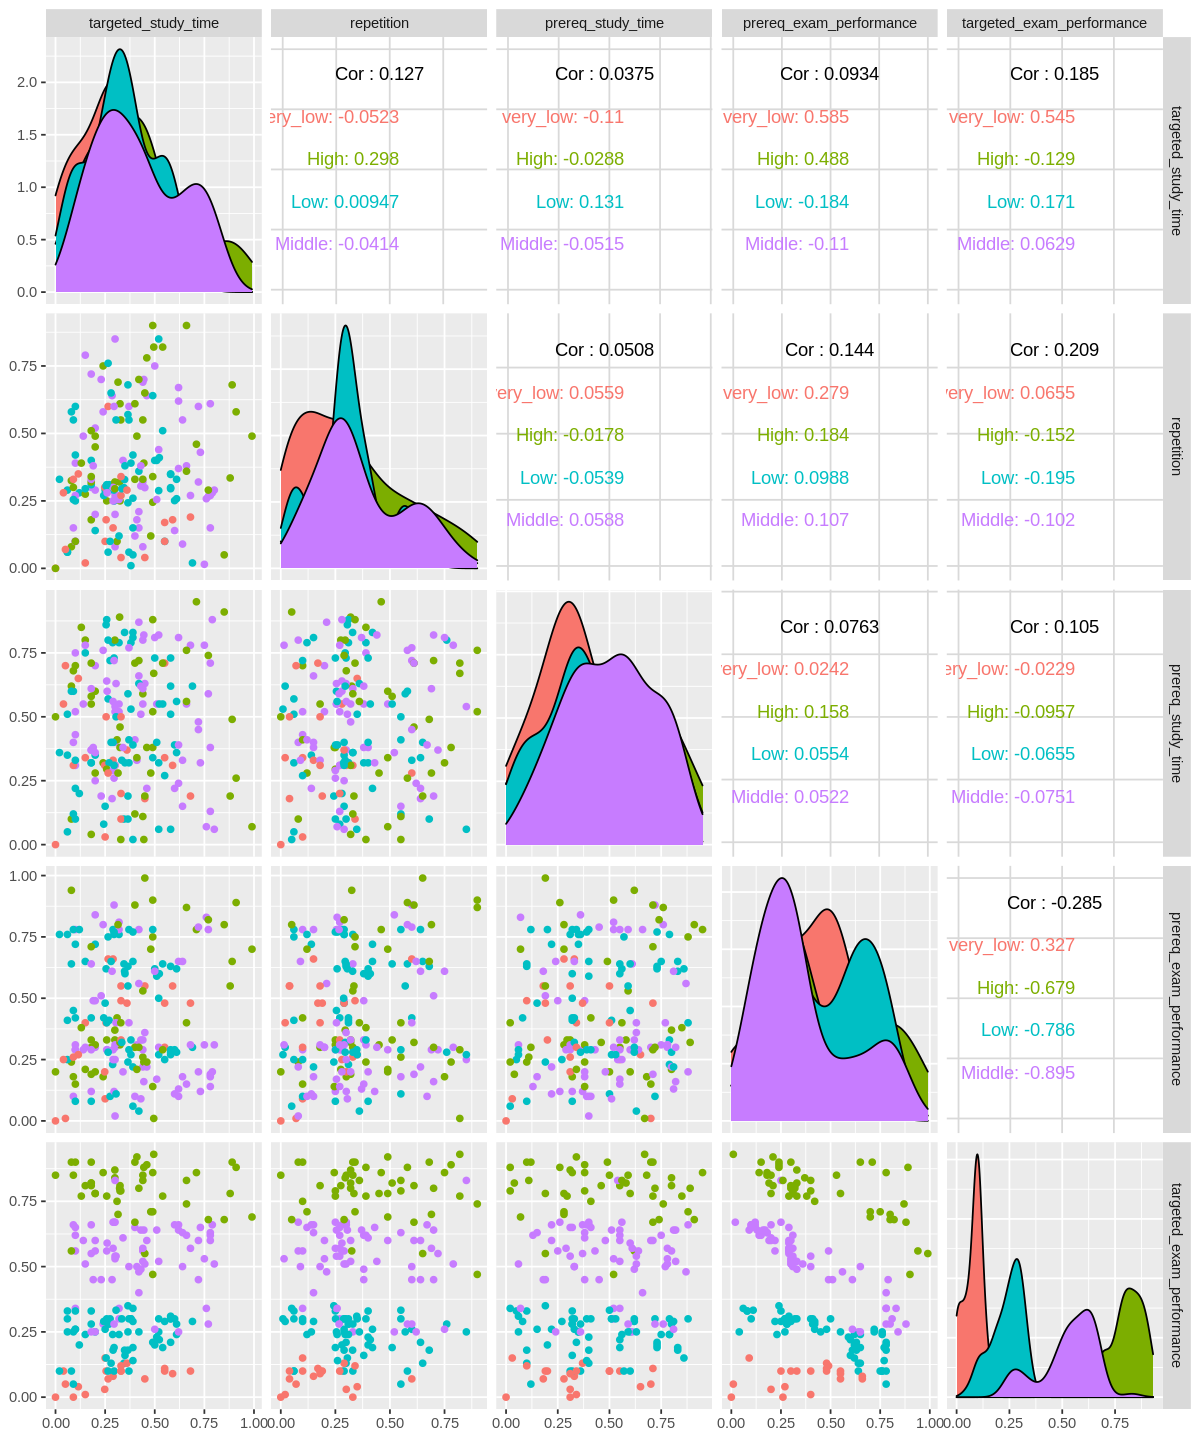

In [10]:
options(repr.plot.width = 10, repr.plot.height = 12)

pairs <- knowledge_train %>%
    ggpairs(columns = 1:5, mapping=ggplot2::aes(colour = understanding_level)) +
        theme(legend.position = "bottom")

pairs
# how do we add a legend?

From this visualization, we can see that `targeted_exam_performance` is a predictor we definitely want to include in our model, since all other predictors, when compared with it, produce tightly clustered groups of `understanding_level`s. Furthermore, we can see that `prereq_exam_performance` and `targeted_exam_performance` form the tightest clustering, although the other predictors coupled with `targeted_exam_performance` do separate the groups also. For now, we can be confident that we want to include both `prereq_exam_performance`and `targeted_exam_performance` as predictors in our final model.

# Choosing Predictors with Forward Selection


To choose our final predictors, we will go through the process of forward selection. This essentially creates a model for every possible combination of predictors and compares the accuracies of each one. We will choose the combination of predictors that gives us the highest accuracy.

### ****Step 1****
To begin our forward selection process, we will first create a tibble to store our results.

In [11]:
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>


### ****Step 2****
Since we will use the same specification throughout this process, we will create at the beginning.

In [12]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

### ****Step 3****
Now we will create a 10-vold cross-validation object. We are using a 10-fold instead of a 5-fold object because our data set is relatively small.

In [13]:
set.seed(1)
user_vfold <- vfold_cv(knowledge_train, v = 10, strata = understanding_level)

### ****Step 4****
Since we do not have forward selection in R, we need to prepare several things. First we get the names of all the potential predictors, and also store the total number of predictors.

In [14]:
names <- colnames(knowledge_train %>% select(-understanding_level))

In [15]:
n_total <- length(names)

We should also store the selected predictors.

In [16]:
selected <- c()

### ****Step 5****
Now let us perform the forward selection: we use a for loop to iterate through all the unselected predictors to determine the ones that gives the highest accuracy, and store the results into the tibble we created earlier.

In [17]:
set.seed(1)
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("understanding_level", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe <- recipe(as.formula(model_string), 
                              data = knowledge_train) %>%
        step_scale(all_predictors()) %>%
        step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(user_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = user_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,understanding_level ~ targeted_exam_performance,0.8524896
2,understanding_level ~ targeted_exam_performance+prereq_exam_performance,0.9596032
3,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition,0.9384670
4,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition+targeted_study_time,0.8767502
5,understanding_level ~ targeted_exam_performance+prereq_exam_performance+repetition+targeted_study_time+prereq_study_time,0.7860109


## Conclusion of Choosing Predictors
By comparing the accuracies, we can conclude that we should use `targeted_exam_performance` and `prerequisite_exam_performance` as our predictors, since these give the highest accuracy of ~96%. This perfectly matches what we had seen in our visualization earlier, with the tightly clustered groups when we plotted `targeted_exam_performance` and `prerequisite_exam_performance` against each other. 

## **Visualizing Our Results**


There are two ways that we will visualize the results of our final model. 

Firstly, because we expect the accuracy of our model to be very high, and because our data set is quite small, we don't expect many observations from our testing set to be incorrectly predicted. We can thus create two plots, with the x and y axis as our two predictors: one with the observations colour-coded as their *predicted* class lable, and another with the observations colour-coded as their *actual* class labels. Then, we can simply circle the observations that the model got incorrect and discuss these inaccuracies.

Secondly, because we are interested in analyzing whether the model potentially leaned towards over- or under-predicting the knowledge level of our observations, we can use a confusion matrix to compare false positives and negatives. We can discuss whether a higher false prediction (i.e. predicting an incorrect `high` knowledge level for a `low` observation) or a lower false prediction (i.e. predicting an incorrect `low` knowledge level for a `high` observation) is more meaningful/has greater consequences.

## **Model Expectations**

Now that we have fully analyzed our data, we expect to find that students with higher prerequisite knowledge and exam score will be classified as having a higher knowledge level.     

# ***Our Final Classification Model***

Now that we know what predictors we are going to use - `targeted_exam_performance` and `prerequisite_exam_performance` - we can create our final model. Note that we use the training data throughout this process.


First of all, we will create a final recipe with these two predictors. As previously mentioned, we do not *need* to scale and center our data since our data appears to be standardized already, however, we will standardize it again to ensure we get the best possible results from our model. 

In [18]:
user_recipe_final <- recipe(understanding_level ~ prereq_exam_performance + targeted_exam_performance, data = knowledge_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

We will need a knn model specification as well, specifying `neighbors = tune()` since we will first be choosing our k value.

In [19]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

To help us choose our k value, we will cross validate. So we create a 10-fold cross-validation model. Recall that we use a 10-fold because our dataset is small.

In [20]:
set.seed(1)
user_vfold <- vfold_cv(knowledge_train, v = 10, strata = understanding_level)

Now let's create a tibble with different k values. As discussed previously, the range of k value that we choose to test depends largely on the size of our smallest class label in our training data set. Let's remind ourselves of what that value was. 

In [36]:
knowledge_labels

understanding_level,count
<fct>,<int>
very_low,20
High,47
Low,62
Middle,66


Observe that our smallest class label is `very_low` with only 20 observations. This means that our k value must not *exceed* a value of 40, since any k above 40 would mean that the `very_low` class label will *never* have enough voting power - even if all 20 of the `very_low` observations are within the k nearest points, it would never achieve a majority vote. Our model would never predict the `very_low` category. 

To reduce the possibility of a 'tie', we will let our 'maximum-k-value-to-try' be 39 instead of 40. 

In [22]:
gridvals <- tibble(neighbors = seq(1,39))

Finally, we combine everything into a workflow and collect metrics on our model.

In [23]:
knn_results <- workflow() %>%
  add_recipe(user_recipe_final) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = user_vfold, grid = gridvals) %>%
  collect_metrics()

Filter for the accuracy metrics.

In [24]:
accuracies <- knn_results %>%
  filter(.metric == "accuracy")

Let us create a graph to visualize the relationship between K values and accuracies. This will help us choose our k value.

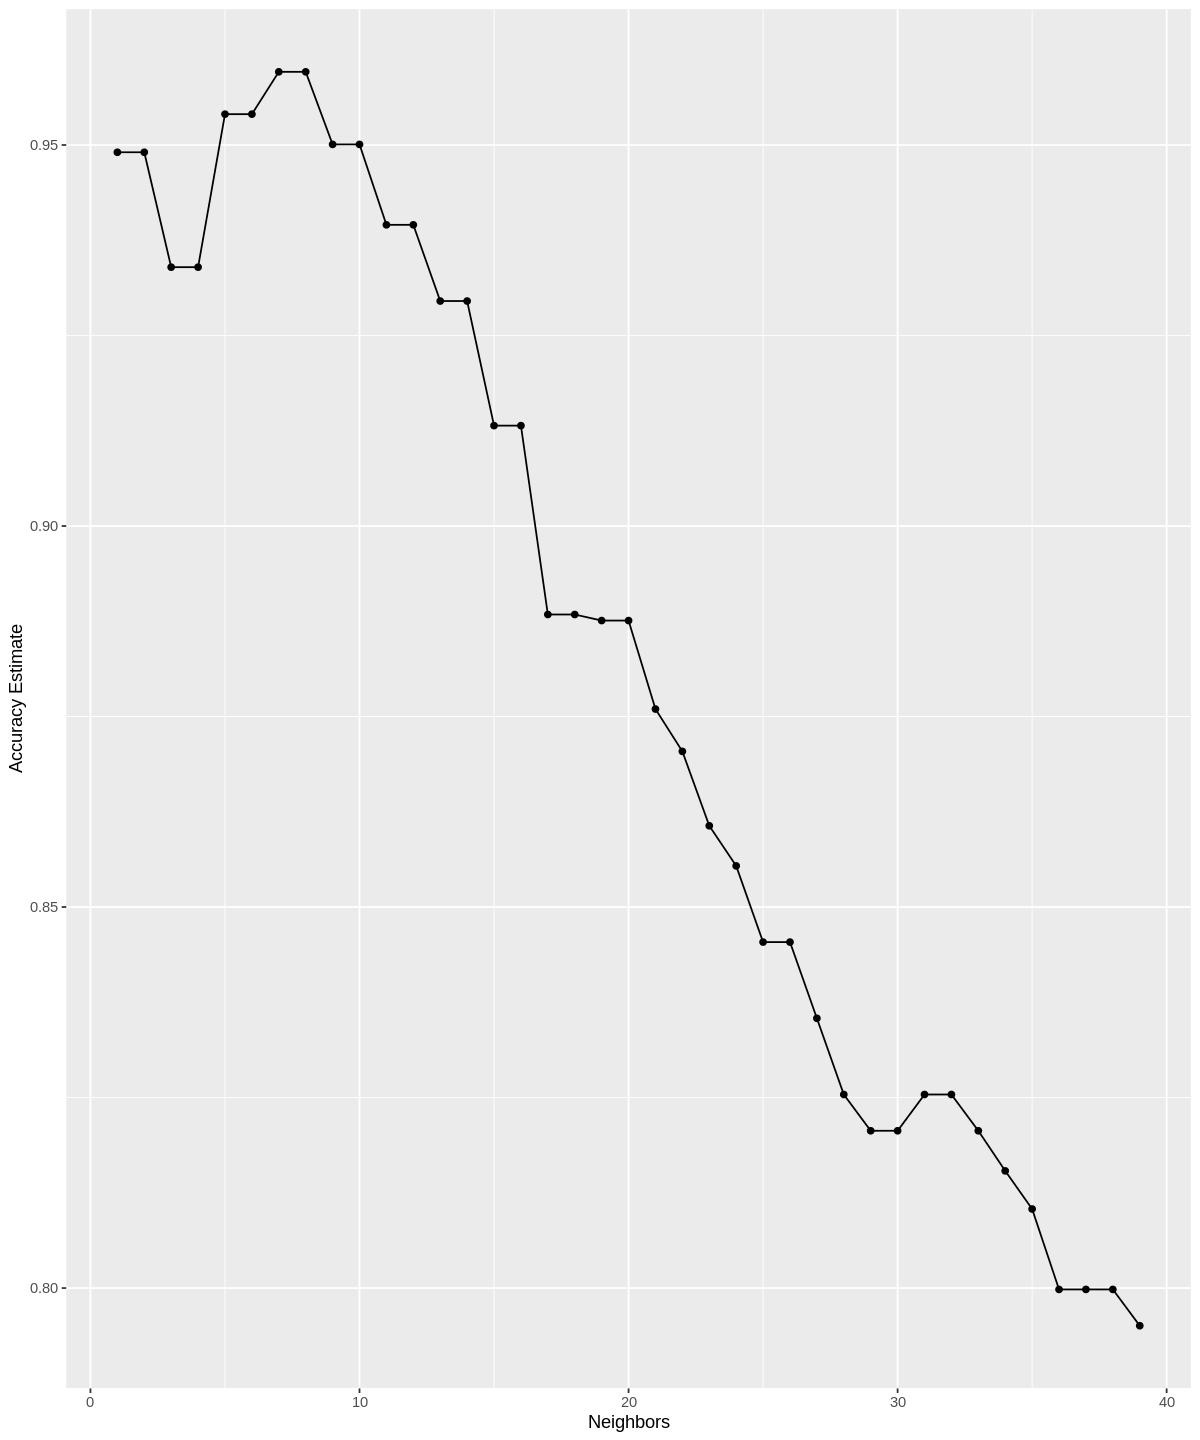

In [25]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_vs_k

Now we can decide which k value to use. To do this, we will keep three principles in mind. Our k value must:
1. ensure we get rough optimal accuracy
2. be relatively stable (i.e. increasing or decreasing the k value by a small amount doesn't change the accuracy of our model too much)
3. not be too large

We can see that between k = 1 and k = 10, our k values are quite high, stable, and obviously not too large. We also note that the accuracy of our model decreases sharply after k = 10, so we do not want to choose our k value to be greater than 10. Furthermore, while there is a seemingly big dip in the k values from k = 2 to k = 5, note that the scale of the x axis means the dip looks much bigger than it truly is. So we know we want to look for a k in that area. 

Since the k values don't change too much within k = 1 and k = 10, we are free to choose a k that gives us the highest accuracy within this range. This value would be either k = 6 or k = 7. Because their accuracies are exactly the same, we then move to comparing how much the accuracies change when we increase and decrease the k value. 

Observe that the difference in accuracy between from k = 7 to k = 8 is greater than the difference in accuracy between k = 5 and k = 6. For this reason, we will choose **k = 6**. However, note that the differences between k = 6 and k = 7 are so incredibly minute that it likely would not impact our model significantly if we had chosen k = 7. 

# ***Our Final Classification Model With K = 6***

Now we should create a new specification model with k = 6.

In [26]:
user_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
  set_engine("kknn") %>%
  set_mode("classification")

We put the new specification into the workflow and reuse the previous recipe.

In [27]:
user_fit_final <- workflow() %>%
    add_model(user_spec_final) %>%
    add_recipe(user_recipe_final) %>%
    fit(knowledge_train)

Now let us predict the test set that we separated earlier. 

In [28]:
user_prediction <- user_fit_final %>%
    predict(knowledge_test) %>%
    bind_cols(knowledge_test)

Finally, let us view the accuracy of our prediction.

In [29]:
user_prediction_accuracy <-  user_prediction %>%
  metrics(truth = understanding_level, estimate = .pred_class) %>%
  filter(.metric == "accuracy")

user_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9365079


We will analyze the results of our classifiers after we have visualized our results also via plots and a confusion matrix. 

## Visualization of model results

Now we can visualize our results by plotting two graphs as previously described: one that classifies the observations by their predicted class, and one that classifies them by their actual class. We can then find the incorrectly classified points, circle them, and later analyze them.

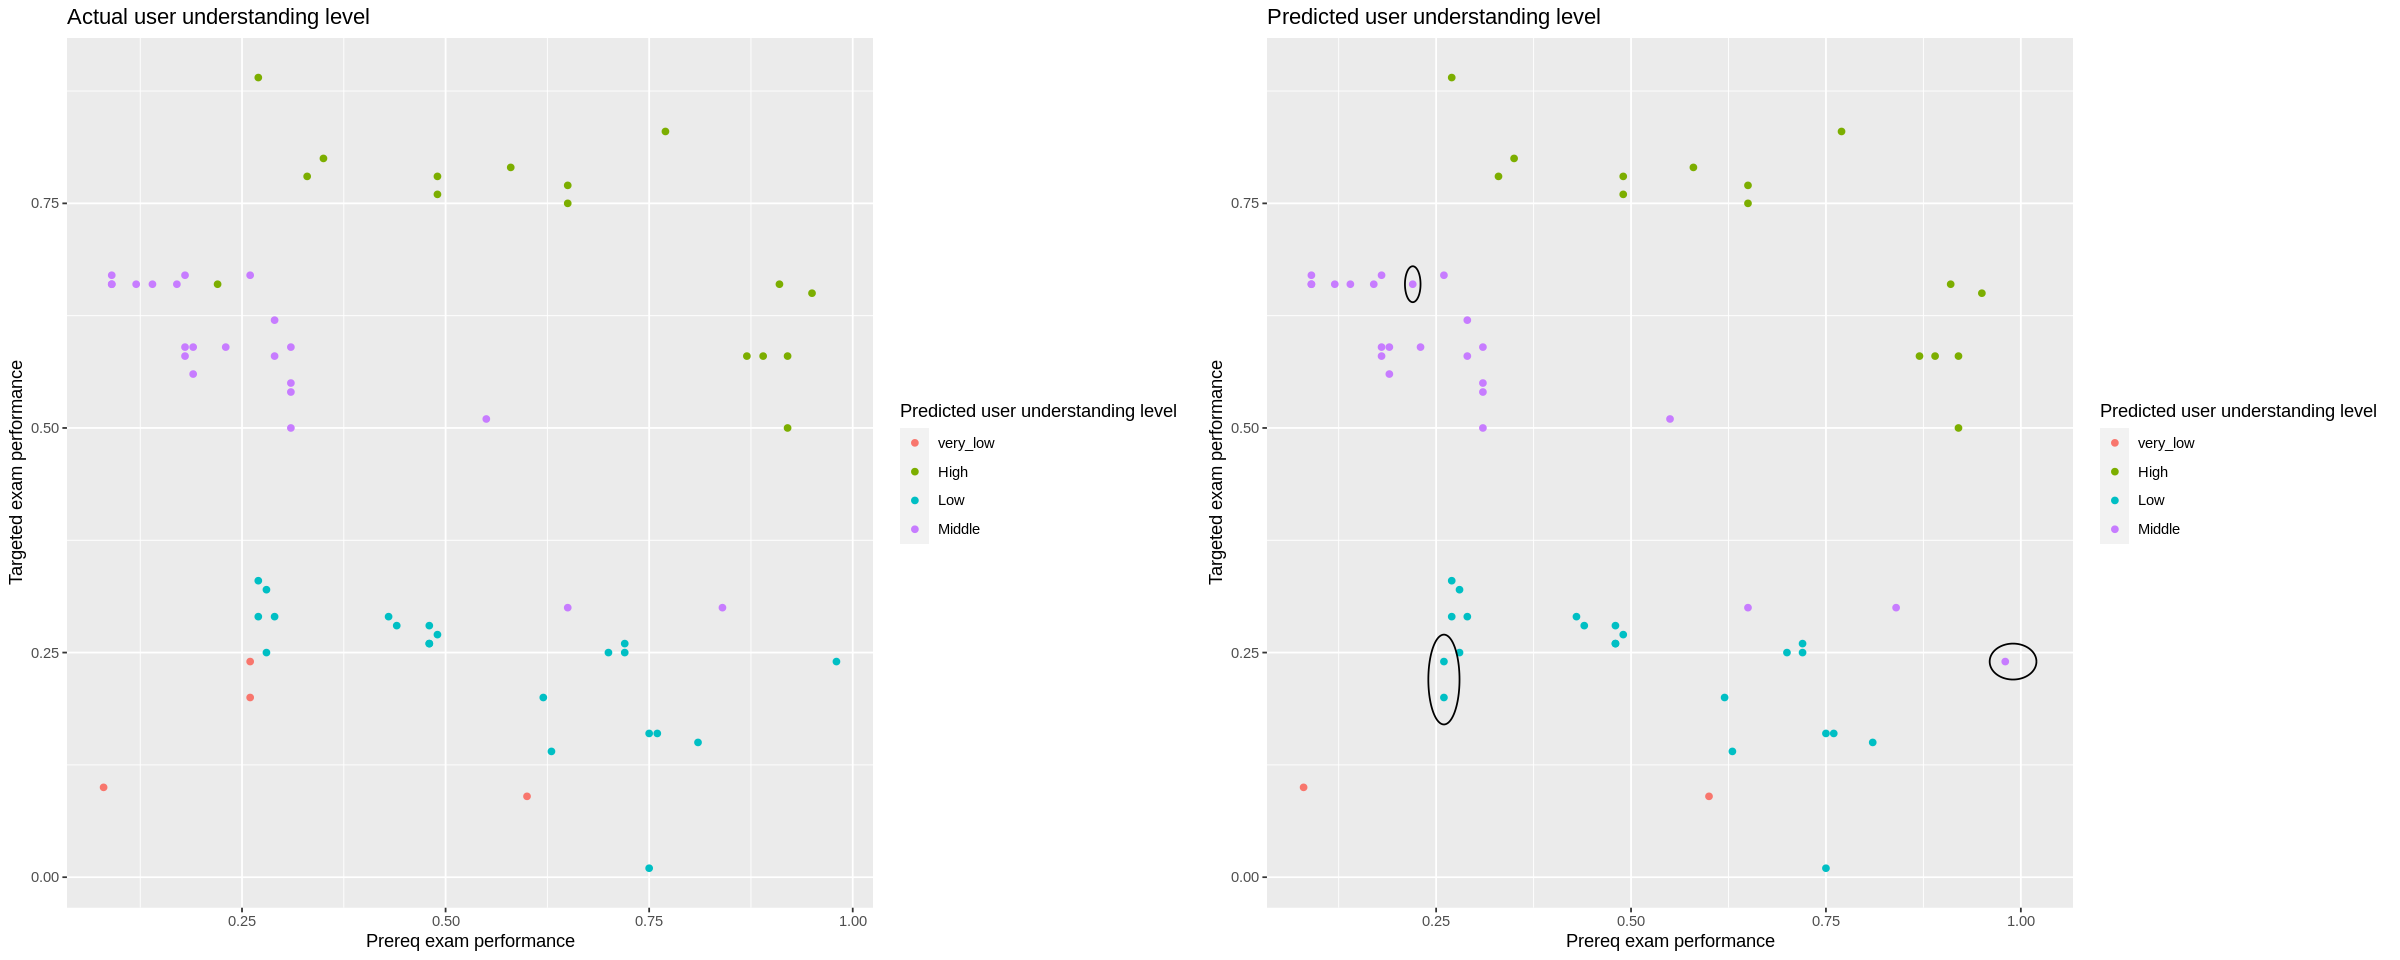

In [34]:
options(repr.plot.width = 20, repr.plot.height = 8)

# create vectors containing the coordinates of the incorrectly-labelled points to circle
upper_left_point <- c(0.22,0.66)
lower_left_points <- c(0.26,0.22)
lower_right_point <- c(0.99,0.24)

# predicted labels plot
user_predicted_plot <- user_prediction %>% 
    ggplot(aes(x = prereq_exam_performance, y = targeted_exam_performance, color = .pred_class)) +
        geom_point() + 
        labs(x = "Prereq exam performance", y = "Targeted exam performance", color = "Predicted user understanding level") +
        ggtitle("Predicted user understanding level") +
        # now we circle the incorrectly labelled points
        annotate("path", 
                     x=upper_left_point[1] + 0.01*cos(seq(0,2*pi,length.out=100)),
                     y=upper_left_point[2] + 0.02*sin(seq(0,2*pi,length.out=100))) +
         annotate("path", 
                     x=lower_left_points[1] + 0.02*cos(seq(0,2*pi,length.out=100)),
                     y=lower_left_points[2] + 0.05*sin(seq(0,2*pi,length.out=100))) +
        annotate("path", 
                     x=lower_right_point[1] + 0.03*cos(seq(0,2*pi,length.out=100)),
                     y=lower_right_point[2] + 0.02*sin(seq(0,2*pi,length.out=100)))

# actual labels plot
user_class_plot <- user_prediction %>% 
    ggplot(aes(x = prereq_exam_performance, y = targeted_exam_performance, color = understanding_level)) +
        geom_point() + 
        labs(x = "Prereq exam performance", y = "Targeted exam performance", color = "Predicted user understanding level") +
        ggtitle("Actual user understanding level")


plot_grid(user_class_plot, user_predicted_plot, nrow = 1)

## Confusion Matrix

The final tool in our toolkit for analyzing the results of our model is the confusion matrix. Let's create one.

In [31]:
user_mat <- user_prediction %>%
    conf_mat(truth = understanding_level, estimate = .pred_class)
user_mat

          Truth
Prediction very_low High Low Middle
  very_low        2    0   0      0
  High            0   15   0      0
  Low             2    0  20      0
  Middle          0    1   1     22

# **Final Analysis**

With our three analysis tools - the model's accuracy levels, the two visualizations, and the confusion matrix - we can now analyze our model and results. 

As expected, we found that students with higher prerequisite knowledge and exam score will be classified as having a higher knowledge level.

These findings could highlight the importance of having a solid foundation of basic knowledge prior to learning more complex materials, and describe how the amount of time studied influences one’s knowledge level. Some future questions that our analysis could lead to are "what factors determine/influence exam performance?" and "what other study methods, other than amount of time studied, can influence exam performance?". 

---
Let's now discuss the model's accuracy. 

The accuracy of our classifier is incredibly high. While this may initially give cause for concern (i.e. perhaps we mixed up our training and testing data somewhere), upon closer inspection we can see that this is to be expected. 

Firstly, from our forward selection we saw that the highest accuracy of our model is when we used two predictors, for an accuracy of about ~95%. Secondly, we saw this high accuracy when we chose our k value of 6. Lastly, in our initial visualization we noticed extremely tight clustering between our `targeted_exam_performance` and `prerequisite_exam_performance` predictors. This last point gives us a very good visual understanding of how and why our classifier accuracy is so high: with a good k value, the tight clustering means that our model will have an easier time classifying an observation based on the class of its neighbors.  

---
We can see this incredibly high accuracy in our two plots also. Note that there are only 4 incorrectly labelled points. Also note that some of these points were very difficult to label - with the exception of the observation in the upper left corner, the other three incorrectly-labelled observations were all on the border of two classes. The point in the upper left corner seems to be an anomaly, as it's almost entirely surrounded by `middle` observations, yet is classified as `high` in the original data set. It is thus understandable that our model made this mistake. 

---
The confusion matrix tells us what type of incorrect predictions our model made. Because we have 4 different labels, we cannot describe our prediction types as simply "negative" or "positive", so we have grouped the types of incorrect predictions into two categories: 

1. **overestimate**:
    this is any classification where the model inaccurately predicts a *higher* knowledge level than the observation actually has
2. **underestimate**:
    this is any classification where the model inaccurately predicts a *lower* knowledge level than the observation actually has
    
Given the context of our data, we consider two other ways we can analyze the contextual accuracy of our model: 

### a. we consider **overestimates** to have "worse" consequences than underestimates. 

### b. the more knowledge levels a prediction "skips", the "worse" the consequences.

By "worse" consequences, we mean that the model's incorrect prediction would be more significant in the real world. Let's elaborate on these two points.

Consider the following scenario: 

An online, self-learning module continuously takes input from the user to understand what their current knowledge level is (i.e. based on their exam scores for prerequisite and targeted topics). In other words, the module is building up an understanding of how well the student understands the topic. Say the module gives students quizzes. It chooses the difficulty of questions to present to the student based on what it thinks the student's understanding level is. Then we consider the following further scenarios: 
1. If the model gives the student a question that is slightly easier than their understanding level, it is better than the model giving the student a question that is *much* too easy for their understanding level. The student will not progress their knowledge, or adequately test their current knowledge, with this question
2. Likewise, if the model gives the student a question that is slightly *harder* than their understanding level, it is better than a question that is *incredibly* difficult for the student. They may be discouraged and be less likely to continue learning. 
3. Regardless of the degree to which the model incorrectly predicts the student's understanding level, it is better, in general, for the model to provide the student with simpler questions than more difficult questions. This is because simpler questions will be more likely to reinforce the student's current understanding (which, even if the student finds them too easy, can still be considered as having positive or neutral consequences). Harder questions, on the other hand, have potential for severe negative consequences if the question is too far out of the student's understanding level. While a small challenge is good for expanding the student's understanding, the risk of choosing a question that is much too difficult may outweigh this small benefit. 

Points 1 and 2 highlight point b above. Point 3 highlights point a. 

We can consider another scenario:

An employer is open for hiring. They interview and accept two candidates: one who presents as very smart, but upon entering the workforce, turns out to be much less knowledgable than they boasted to be; and one who presents as not very knowledgeable in the hiring process, but turns out to have invaluable knowledge that just wasn't presentable in the interview. Which of these two employees would be more valuable to the company? Clearly, the answer to this question would be the employer who was *initially underestimated* but later proved themselves to be more knowledgeable. Likewise, by this analogy it is better for our model to *underestimate* a user's knowledge level than overestimate it.

These two scenarios help us understand that it is better for our model to underestimate user knowledge to a small degree, versus overestimate user knowledge to a large degree. With that in mind, let us analyze our confusion matrix. 

In [35]:
user_mat

          Truth
Prediction very_low High Low Middle
  very_low        2    0   0      0
  High            0   15   0      0
  Low             2    0  20      0
  Middle          0    1   1     22

Our model made 4 incorrect classifications. Let's categorize them based on what we discussed above. 

- 3 observations were underestimated (two were supposed to be `low`, but predicted `very_low`; one was supposed to be `middle` but predicted `low`)
- 1 observation was overestimated (supposed to be `middle`, but predicted `high`)

Thus our model has performed well according to the context-based metrics we discussed. It has predicted more underestimates than overestimates, and each inaccurate prediction was only one category off (i.e. degree of inaccuracy is small). It's important to note that because our data set is so small, the significance of these findings is not incredibly high.

---
There are, however, some issues with our model that we can discuss also. 

Firstly, our data set is very small. Had we had access to a larger data set, it is likely that our model's accuracy would not be this high. There would be many more anomalies in our data like the point in the upper left corner of our plot. Secondly, our model unfortunately doesn't use the much greater variety of data that we have access to: the other predictors. It just so happens that the correlation between our class label and our predictors was strongest in the two predictors we picked, however, it would be interesting to see what other correlations could be drawn from the other predictors. 

# Conclusion

We can conclude that our model's accuracy is incredibly high, and also performed well in context-based scenarios. We also note, however, that this high accuracy is partially credited towards our small data set. 